In [2]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

# !pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!pip install -q torchsde xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (2140/2140), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 14652 (delta 2060), reused 1977 (delta 1977), pack-reused 12512 (from 1)
Receiving objects: 100% (14652/14652), 22.40 MiB | 27.15 MiB/s, done.
Resolving deltas: 100% (9899/9899), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1100536520912772350


  0%|          | 0/20 [00:00<?, ?it/s]

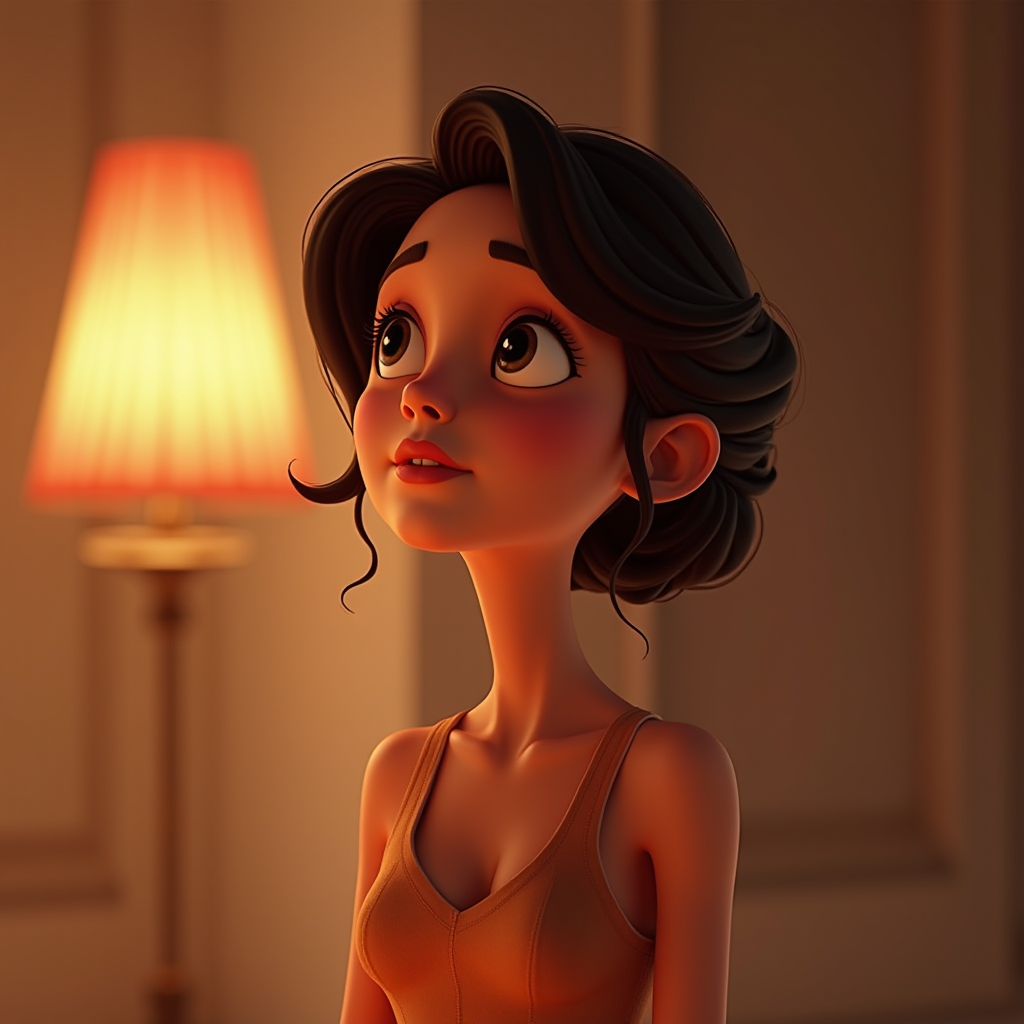

In [6]:
with torch.inference_mode():
    positive_prompt = "Style Pixar 3D Animation, A beautiful woman in a cinematic scene."
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

Dropdown(description='Aspect Ratio:', index=1, options=('1:1', '16:9', '9:16', '3:4', '4:3', '4:5', '5:4'), va…

  0%|          | 0/20 [00:00<?, ?it/s]

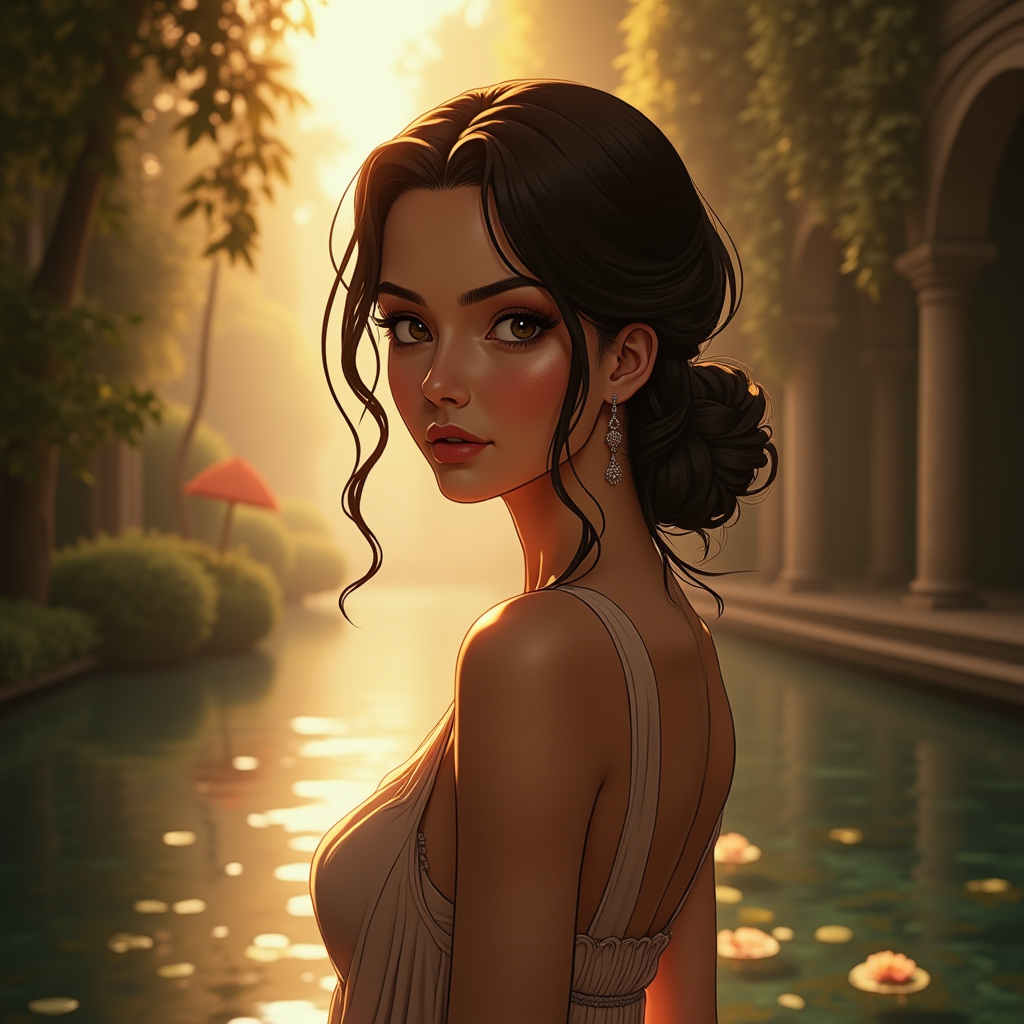

In [8]:
with torch.inference_mode():
    import ipywidgets as widgets
    from IPython.display import display

    positive_prompt = """
        "anime style. A stunningly beautiful woman with captivating features, dressed elegantly in a flowing gown, standing in a dramatic cinematic setting.
        The scene is illuminated by soft, golden hour lighting, casting warm highlights on her face.
        She is surrounded by an enchanting backdrop of lush nature or a grand architectural masterpiece, with a dreamy and atmospheric mood that evokes the style of a classic movie still.
        """
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    # Aspect ratio selection
    aspect_ratios = {
        "1:1": (1, 1),
        "16:9": (16, 9),
        "9:16": (9, 16),
        "3:4": (3, 4),
        "4:3": (4, 3),
        "4:5": (4, 5),
        "5:4": (5, 4)
    }

    # Dropdown widget for aspect ratio selection
    aspect_ratio_dropdown = widgets.Dropdown(
        options=list(aspect_ratios.keys()),
        value="16:9",  # Default value
        description="Aspect Ratio:",
    )

    # Function to update width and height based on selected aspect ratio
    def update_dimensions(change):
        global width, height
        selected_aspect_ratio = change['new']
        base_size = 512  # You can adjust this value
        width = base_size * aspect_ratios[selected_aspect_ratio][0]
        height = base_size * aspect_ratios[selected_aspect_ratio][1]
        width = closestNumber(width, 16)
        height = closestNumber(height, 16)
        print(f"Selected Aspect Ratio: {selected_aspect_ratio}, Width: {width}, Height: {height}")

    # Observe the dropdown for changes
    aspect_ratio_dropdown.observe(update_dimensions, names='value')

    # Display the dropdown widget
    display(aspect_ratio_dropdown)
    seed = 1100536520912772350 # @param {type:"number"}

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux1.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

Dropdown(description='Aspect Ratio:', index=1, options=('1:1', '16:9', '9:16', '3:4', '4:3', '4:5', '5:4'), va…

Dropdown(description='Base Size:', options=(512, 576, 768, 1024, 1280, 1536), value=512)

Textarea(value='Empty', description='String:', placeholder='Type something')

Text(value='0', description='String:', placeholder='Input seed')

Button(description='Generate Image', style=ButtonStyle())

Selected Aspect Ratio: 16:9, Base Size: 512, Width: 512, Height: 288
Starting image generation...
1100536520912772350


  0%|          | 0/20 [00:00<?, ?it/s]

Image generated and saved as '/content/flux1.png'!


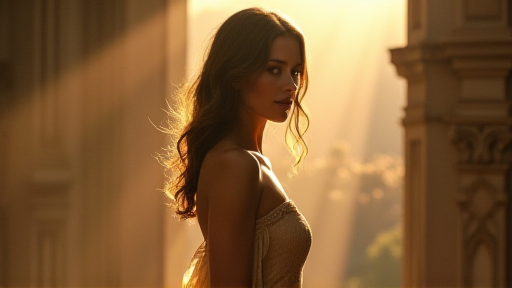

In [11]:
from IPython.display import display, Image as IPyImage
import ipywidgets as widgets
import numpy as np
from PIL import Image
import torch

positive_prompt = """
    "A stunningly beautiful woman with captivating features, dressed elegantly in a flowing gown, standing in a dramatic cinematic setting.
    The scene is illuminated by soft, golden hour lighting, casting warm highlights on her face.
    She is surrounded by an enchanting backdrop of lush nature or a grand architectural masterpiece, with a dreamy and atmospheric mood that evokes the style of a classic movie still.
    """
seed = 0
steps = 20
sampler_name = "euler"
scheduler = "simple"

#Prompt text
positive_prompt_widget = widgets.Textarea(
    value='Empty',
    placeholder='Type something',
    description='Prompt:',
    disabled=False
)

# Dropdown widgets for user input
aspect_ratios = {
    "1:1": (1, 1),
    "16:9": (16, 9),
    "9:16": (9, 16),
    "3:4": (3, 4),
    "4:3": (4, 3),
    "4:5": (4, 5),
    "5:4": (5, 4),
}
base_sizes = [512, 576, 768, 1024, 1280, 1536]

aspect_ratio_dropdown = widgets.Dropdown(
    options=list(aspect_ratios.keys()),
    value="16:9",
    description="Aspect Ratio:",
)
base_size_dropdown = widgets.Dropdown(
    options=base_sizes,
    value=512,
    description="Base Size:",
)
run_button = widgets.Button(description="Generate Image")

# Function to compute width and height
def closestNumber(num, multiple):
    return int(round(num / multiple) * multiple)

def update_dimensions():
    global width, height
    selected_aspect_ratio = aspect_ratio_dropdown.value
    selected_base_size = base_size_dropdown.value
    ratio = aspect_ratios[selected_aspect_ratio]

    if ratio[0] >= ratio[1]:
        width = selected_base_size
        height = int(selected_base_size * ratio[1] / ratio[0])
    else:
        height = selected_base_size
        width = int(selected_base_size * ratio[0] / ratio[1])

    width = closestNumber(width, 16)
    height = closestNumber(height, 16)
    print(f"Selected Aspect Ratio: {selected_aspect_ratio}, Base Size: {selected_base_size}, Width: {width}, Height: {height}")

#Seed widget
seed_widget = widgets.Text(
    value='0',
    placeholder='Input seed',
    description='Seed:',
    disabled=False
)

# Button click callback
def on_run_button_clicked(b):
    update_dimensions()
    print("Starting image generation...")
    seed = int(seed_widget.value) if seed_widget.value else 0
    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)
    positive_prompt = positive_prompt_widget.value
    with torch.no_grad():  # Ensures no gradient tracking
        # Core image generation logic
        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]
        noise = RandomNoise.get_noise(seed)[0]
        guider = BasicGuider.get_guider(unet, cond)[0]
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
        latent_image = EmptyLatentImage.generate(width, height)[0]
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
        model_management.soft_empty_cache()
        decoded = VAEDecode.decode(vae, sample)[0].detach()

        # Save and display the image
        output_path = "/content/flux1.png"
        Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0]).save(output_path)
        print(f"Image generated and saved as '{output_path}'!")
        display(IPyImage(filename=output_path))

# Bind the button click to the function
run_button.on_click(on_run_button_clicked)

# Display widgets
display(aspect_ratio_dropdown)
display(base_size_dropdown)
display(positive_prompt_widget)
display(seed_widget)
display(run_button)
